# AgriFieldNet Data Pipeline

This notebook downloads and prepares the **AgriFieldNet India Challenge** dataset for crop classification using TorchGeo.

## Dataset Overview

| Property | Value |
|----------|-------|
| **Source** | Sentinel-2 satellite imagery |
| **Resolution** | 10m (visible/NIR), 20m (red edge/SWIR) |
| **Tile Size** | 256 × 256 pixels |
| **Total Tiles** | 1,217 tiles |
| **Training Fields** | 5,551 fields |
| **Test Fields** | 1,530 fields |
| **Crop Classes** | 13 classes |

### Crop Classes

| ID | Crop (English) | Crop (Arabic) |
|----|----------------|---------------|
| 1 | Wheat | قمح |
| 2 | Mustard | خردل |
| 3 | Lentil | عدس |
| 4 | No Crop / Fallow | بور |
| 5 | Green Pea | بسلة خضراء |
| 6 | Sugarcane | قصب السكر |
| 8 | Garlic | ثوم |
| 9 | Maize | ذرة صفراء |
| 13 | Gram / Chickpea | حمص |
| 14 | Coriander | كزبرة |
| 15 | Potato | بطاطس |
| 16 | Berseem | برسيم |
| 36 | Rice | أرز |

## 1. Import Libraries

We use **TorchGeo**, a PyTorch library specifically designed for geospatial deep learning.

- **`AgriFieldNet`**: The dataset class that handles loading Sentinel-2 imagery and crop labels
- **`AgriFieldNetDataModule`**: A PyTorch Lightning DataModule that wraps the dataset with DataLoaders, samplers, and train/val/test splits

TorchGeo abstracts away the complexity of:
- Coordinate reference systems (CRS)
- Geospatial file formats (GeoTIFF)
- Multi-resolution band alignment
- Spatial sampling strategies

In [1]:
import os
from torchgeo.datasets import AgriFieldNet
from torchgeo.datamodules import AgriFieldNetDataModule

## 2. Setup Data Directory

Create the local directory where the dataset will be stored. The dataset requires approximately **2-3 GB** of disk space.

```
data/
└── agrifieldnet/
    ├── source/           # Sentinel-2 bands (B01-B12)
    ├── train_labels/     # Crop type labels + field IDs
    └── test_labels/      # Test set field IDs
```

In [2]:
# Create data directory if it doesn't exist
os.makedirs("data/agrifieldnet", exist_ok=True)

## 3. Download the Dataset

This cell downloads the AgriFieldNet dataset from **Source Cooperative** using `azcopy`.

### What gets downloaded:

| Component | Description | Size |
|-----------|-------------|------|
| **Source imagery** | 12 Sentinel-2 spectral bands per tile | ~2 GB |
| **Train labels** | `raster_labels.tif` (crop classes) + `field_ids.tif` | ~500 MB |
| **Test labels** | `field_ids.tif` only (no crop labels) | ~200 MB |

### Sentinel-2 Bands Included:

| Band | Name | Wavelength | Resolution | Purpose |
|------|------|------------|------------|---------|
| B01 | Coastal Aerosol | 443 nm | 60m | Atmospheric correction |
| B02 | Blue | 490 nm | 10m | Water, vegetation |
| B03 | Green | 560 nm | 10m | Vegetation health |
| B04 | Red | 665 nm | 10m | Chlorophyll absorption |
| B05 | Red Edge 1 | 705 nm | 20m | Vegetation stress |
| B06 | Red Edge 2 | 740 nm | 20m | Leaf area index |
| B07 | Red Edge 3 | 783 nm | 20m | Canopy structure |
| B08 | NIR | 842 nm | 10m | Biomass (NDVI) |
| B8A | NIR Narrow | 865 nm | 20m | Water vapor |
| B09 | Water Vapor | 945 nm | 60m | Atmospheric |
| B11 | SWIR 1 | 1610 nm | 20m | Moisture content |
| B12 | SWIR 2 | 2190 nm | 20m | Mineral/dry vegetation |

> **Note**: Download time varies from 10-30 minutes depending on internet speed.

In [3]:
# Download the dataset (this will use azcopy)
# This may take a while depending on your internet connection

dataset = AgriFieldNet(
    paths="data/agrifieldnet",
    download=True,  # This triggers the download
)

## 4. Verify the Dataset

After download, we verify the dataset loaded correctly by checking:

- **CRS (Coordinate Reference System)**: The geographic projection used (typically EPSG:32643 - UTM Zone 43N for India)
- **Bands**: List of available spectral bands
- **Files**: Number of GeoTIFF files indexed by TorchGeo

### Expected Output:
```
Dataset CRS: EPSG:32643
Dataset bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')
Number of files: 1217
```

In [4]:
# Verify the dataset
print(f"Dataset CRS: {dataset.crs}")
print(f"Dataset bands: {dataset.bands}")
print(f"Number of files: {len(dataset.files)}")

Dataset CRS: PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]
Dataset bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')
Number of files: 1217


## 5. Setup PyTorch Lightning DataModule

The `AgriFieldNetDataModule` provides a complete data pipeline for training:

### Parameters:

| Parameter | Value | Description |
|-----------|-------|-------------|
| `batch_size` | 32 | Number of samples per training batch |
| `patch_size` | 256 | Size of each image patch (256×256 pixels) |
| `num_workers` | 4 | Parallel data loading threads |
| `paths` | "data/agrifieldnet" | Location of downloaded data |

### What `setup("fit")` does:

1. **Indexes** all GeoTIFF files in the dataset
2. **Creates spatial index** for efficient sampling
3. **Splits** data into training and validation sets
4. **Prepares** RandomGeoSampler for training batches

### DataModule Methods:

```python
datamodule.train_dataloader()  # Returns training DataLoader
datamodule.val_dataloader()    # Returns validation DataLoader
datamodule.test_dataloader()   # Returns test DataLoader
```

### Batch Structure:

Each batch from the DataLoader contains a dictionary:
```python
{
    "image": Tensor[B, C, H, W],  # B=batch, C=12 bands, H=W=256
    "mask": Tensor[B, H, W],      # Crop class labels (0-36)
}
```

In [5]:
# Now you can use the DataModule
datamodule = AgriFieldNetDataModule(
    batch_size=32,
    patch_size=256,
    num_workers=4,
    paths="data/agrifieldnet",
)

# Prepare data (sets up train/val/test splits)
datamodule.setup("fit")

---

# Part 2: Custom Data Preprocessing Pipeline

The TorchGeo DataModule above is useful for quick experimentation, but for production training we need:
1. **Faster loading** - Pre-processed `.npy` files load much faster than GeoTIFFs
2. **Consistent normalization** - Z-score normalization computed from training set only
3. **Fixed train/val splits** - Reproducible splits saved to CSV files
4. **Memory efficiency** - Load entire dataset to GPU memory for fast training

The following cells run our custom preprocessing pipeline from `backend/src/data/prepare_dataset.py`.

## 6. Run the Preprocessing Pipeline

This script will:
1. Scan all tiles in `data/agrifieldnet/source/`
2. Compute per-band normalization statistics (mean, std) from training tiles only
3. Create 80/20 train/val split with fixed random seed (42)
4. Generate normalized `.npy` files for fast PyTorch loading
5. Save metadata (`class_map.json`, `normalization_stats.json`)

### Output Structure:
```
data/
├── processed/
│   ├── train_images.npy          # (N_train, 12, 256, 256) float32
│   ├── train_masks.npy           # (N_train, 256, 256) int64
│   ├── val_images.npy            # (N_val, 12, 256, 256) float32
│   ├── val_masks.npy             # (N_val, 256, 256) int64
│   ├── normalization_stats.json  # Per-band mean and std
│   └── class_map.json            # Class ID → name/color mapping
└── splits/
    ├── train_ids.csv             # Training tile IDs
    └── val_ids.csv               # Validation tile IDs
```

> **Note**: This may take 10-30 minutes depending on your hardware.

In [ ]:
# Run the preprocessing pipeline
# This imports and runs the main() function from prepare_dataset.py

import sys
sys.path.insert(0, ".")  # Add project root to path

from backend.src.data.prepare_dataset import main as run_preprocessing

# Run the full preprocessing pipeline
run_preprocessing()

## 7. Verify the Processed Data

Let's verify that the preprocessing completed successfully by:
1. Loading the generated `.npy` files
2. Checking array shapes and data types
3. Verifying normalization (mean ≈ 0, std ≈ 1)

In [2]:
import numpy as np
import json
from pathlib import Path

# Load processed data
data_dir = Path("data/processed")

train_images = np.load(data_dir / "train_images.npy")
train_masks = np.load(data_dir / "train_masks.npy")
val_images = np.load(data_dir / "val_images.npy")
val_masks = np.load(data_dir / "val_masks.npy")

# Print shapes and dtypes
print("=" * 50)
print("Dataset Shapes:")
print("=" * 50)
print(f"train_images: {train_images.shape} ({train_images.dtype})")
print(f"train_masks:  {train_masks.shape} ({train_masks.dtype})")
print(f"val_images:   {val_images.shape} ({val_images.dtype})")
print(f"val_masks:    {val_masks.shape} ({val_masks.dtype})")

# Verify normalization
print("\n" + "=" * 50)
print("Normalization Verification (per-band):")
print("=" * 50)
print(f"{'Band':<6} {'Mean':>10} {'Std':>10}")
print("-" * 28)
for i in range(train_images.shape[1]):
    mean = train_images[:, i, :, :].mean()
    std = train_images[:, i, :, :].std()
    print(f"Band {i:<2} {mean:>10.4f} {std:>10.4f}")

# Load and display class map (use UTF-8 encoding for Arabic text)
with open(data_dir / "class_map.json", encoding="utf-8") as f:
    class_map = json.load(f)

print("\n" + "=" * 50)
print("Class Distribution:")
print("=" * 50)
print(f"{'ID':<4} {'Name':<15} {'Pixels':>12} {'Percentage':>10}")
print("-" * 45)
total_pixels = sum(class_map["class_counts"].values())
for cls_id, count in sorted(class_map["class_counts"].items(), key=lambda x: -x[1]):
    cls_info = class_map["classes"].get(str(cls_id), {"name": "Unknown"})
    pct = count / total_pixels * 100
    print(f"{cls_id:<4} {cls_info['name']:<15} {count:>12,} {pct:>9.2f}%")

Dataset Shapes:
train_images: (932, 12, 256, 256) (float32)
train_masks:  (932, 256, 256) (int64)
val_images:   (233, 12, 256, 256) (float32)
val_masks:    (233, 256, 256) (int64)

Normalization Verification (per-band):
Band         Mean        Std
----------------------------
Band 0      0.1629     1.0719
Band 1      0.1159     1.0882
Band 2      0.0255     1.1310
Band 3      0.0114     1.0808
Band 4      0.0095     1.0909
Band 5      0.0413     1.0944
Band 6      0.0447     1.0992
Band 7      0.0466     1.1045
Band 8      0.0827     1.0883
Band 9     -0.2788     1.0540
Band 10     0.1479     1.0719
Band 11     0.0491     1.0992

Class Distribution:
ID   Name                  Pixels Percentage
---------------------------------------------
0    Background        76,161,212     99.75%
1    Wheat                 75,118      0.10%
2    Mustard               46,818      0.06%
4    No Crop               36,397      0.05%
9    Maize                  8,773      0.01%
6    Sugarcane           

## 8. Visualize Sample Tiles

Let's visualize a few sample tiles to verify the data looks correct:
- **Left**: RGB composite (bands B04, B03, B02 = Red, Green, Blue)
- **Right**: Crop mask with class colors

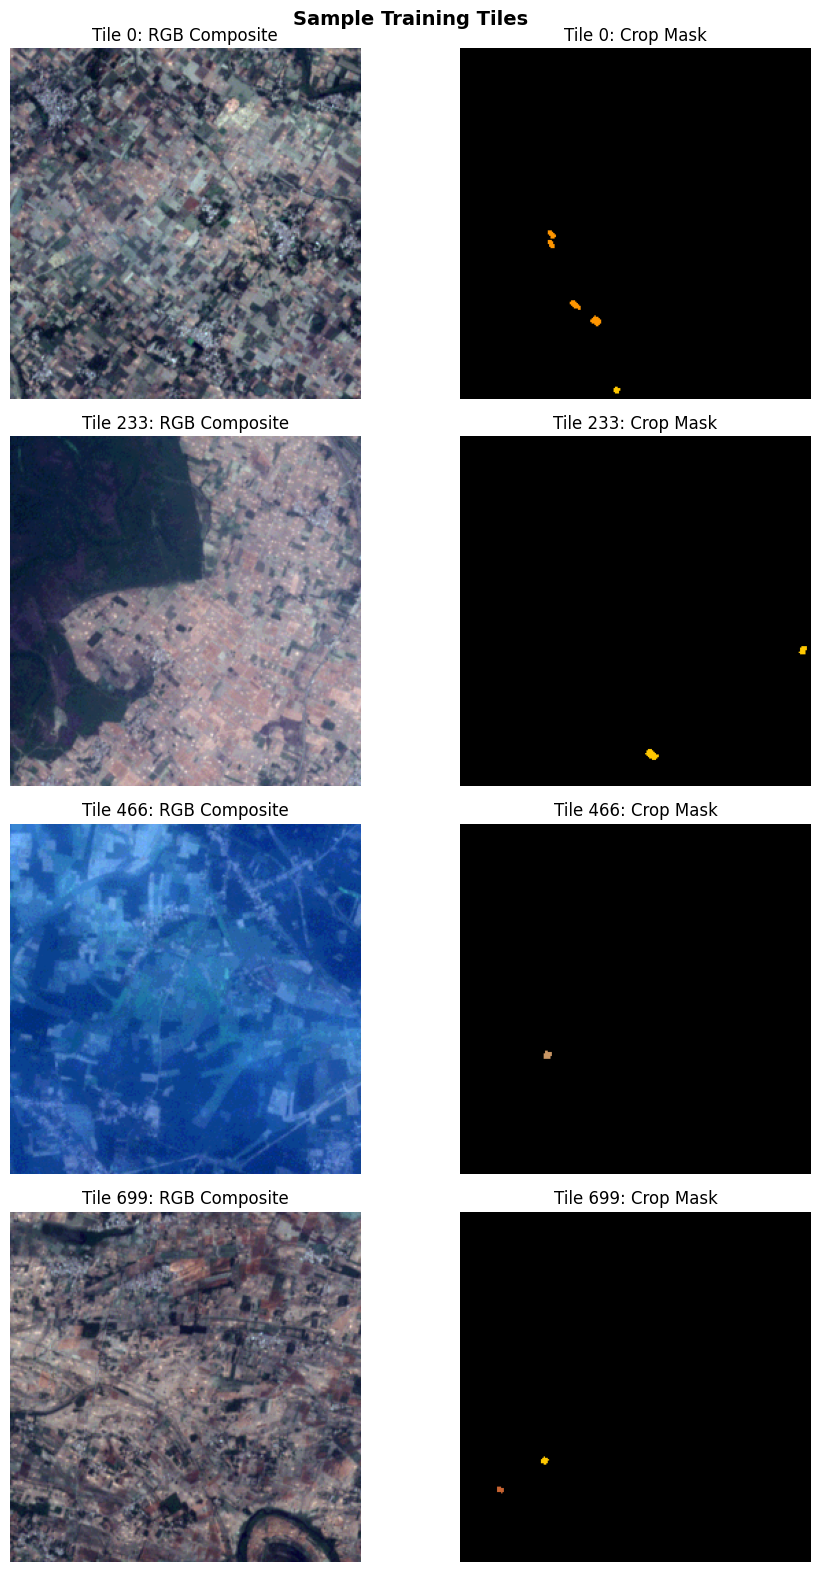


Class Legend:
----------------------------------------
   0: Background      RGB(0, 0, 0)
   1: Wheat           RGB(255, 200, 0)
   2: Mustard         RGB(255, 150, 0)
   3: Lentil          RGB(200, 100, 50)
   4: No Crop         RGB(128, 128, 128)
   5: Green Pea       RGB(0, 200, 0)
   6: Sugarcane       RGB(100, 200, 100)
   8: Garlic          RGB(200, 150, 200)
   9: Maize           RGB(255, 255, 0)
  13: Gram            RGB(150, 100, 50)
  14: Coriander       RGB(0, 150, 100)
  15: Potato          RGB(200, 150, 100)
  16: Berseem         RGB(0, 255, 150)
  36: Rice            RGB(0, 100, 255)


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_rgb_composite(image, bands=(3, 2, 1)):
    """
    Create RGB composite from multi-band image.
    
    Parameters:
    - image: (C, H, W) normalized image array
    - bands: tuple of band indices for (R, G, B) - default is (B04, B03, B02)
    
    Returns:
    - (H, W, 3) RGB array scaled to 0-1
    """
    rgb = np.stack([image[b] for b in bands], axis=-1)
    # Rescale from normalized to 0-1 for display
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
    return np.clip(rgb, 0, 1)

def create_mask_rgb(mask, class_colors):
    """
    Create RGB visualization of class mask.
    
    Parameters:
    - mask: (H, W) integer class labels
    - class_colors: dict mapping class_id -> [R, G, B]
    
    Returns:
    - (H, W, 3) RGB array scaled to 0-1
    """
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.float32)
    
    for cls_id, color in class_colors.items():
        cls_mask = mask == int(cls_id)
        for c in range(3):
            rgb[:, :, c] += cls_mask * (color[c] / 255.0)
    
    return rgb

# Get class colors from class_map
class_colors = {int(k): v["color"] for k, v in class_map["classes"].items()}

# Plot 4 sample tiles
fig, axes = plt.subplots(4, 2, figsize=(10, 16))
fig.suptitle("Sample Training Tiles", fontsize=14, fontweight="bold")

sample_indices = [0, len(train_images)//4, len(train_images)//2, 3*len(train_images)//4]

for row, idx in enumerate(sample_indices):
    # RGB composite (B04=Red, B03=Green, B02=Blue -> indices 3, 2, 1)
    rgb = create_rgb_composite(train_images[idx], bands=(3, 2, 1))
    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f"Tile {idx}: RGB Composite")
    axes[row, 0].axis("off")
    
    # Mask visualization
    mask_rgb = create_mask_rgb(train_masks[idx], class_colors)
    axes[row, 1].imshow(mask_rgb)
    axes[row, 1].set_title(f"Tile {idx}: Crop Mask")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()

# Create legend
print("\nClass Legend:")
print("-" * 40)
for cls_id in sorted(class_colors.keys()):
    cls_info = class_map["classes"].get(str(cls_id), {"name": "Unknown"})
    color = class_colors[cls_id]
    print(f"  {cls_id:>2}: {cls_info['name']:<15} RGB{tuple(color)}")

## 9. Test PyTorch Dataset Integration

Finally, let's verify that our `CropDataset` class works correctly with PyTorch DataLoader.

This is the interface that Student C (Training) will use to train models.

In [5]:
from backend.src.data.dataset import CropDataset, get_dataloaders, RandomFlipRotate

# Load dataset using our custom class
train_dataset = CropDataset("data/processed", split="train")
val_dataset = CropDataset("data/processed", split="val")

print("=" * 50)
print("CropDataset Properties:")
print("=" * 50)
print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes:  {train_dataset.num_classes}")
print(f"Number of channels: {train_dataset.num_channels}")

# Test single sample
sample = train_dataset[0]
print(f"\nSample batch structure:")
print(f"  image: {sample['image'].shape} ({sample['image'].dtype})")
print(f"  mask:  {sample['mask'].shape} ({sample['mask'].dtype})")

# Test DataLoader (num_workers=0 required for Windows/Jupyter)
train_loader, val_loader = get_dataloaders("data/processed", batch_size=8, num_workers=0)

batch = next(iter(train_loader))
print(f"\nDataLoader batch structure:")
print(f"  image: {batch['image'].shape} ({batch['image'].dtype})")
print(f"  mask:  {batch['mask'].shape} ({batch['mask'].dtype})")

# Test class weights (for handling class imbalance)
weights = train_dataset.get_class_weights()
print(f"\nClass weights shape: {weights.shape}")
print(f"Class weights (first 5): {weights[:5].numpy()}")

print("\n" + "=" * 50)
print("Data Pipeline Complete!")
print("=" * 50)
print("\nNext steps:")
print("  1. Student B: Implement U-Net model in backend/src/models/")
print("  2. Student C: Implement training loop in backend/src/train/")
print("  3. Student D: Implement inference API in backend/src/inference/")

CropDataset Properties:
Training samples:   932
Validation samples: 233
Number of classes:  14
Number of channels: 12

Sample batch structure:
  image: torch.Size([12, 256, 256]) (torch.float32)
  mask:  torch.Size([256, 256]) (torch.int64)

DataLoader batch structure:
  image: torch.Size([8, 12, 256, 256]) (torch.float32)
  mask:  torch.Size([8, 256, 256]) (torch.int64)

Class weights shape: torch.Size([37])
Class weights (first 5): [1.8550378e-05 1.8808000e-02 3.0176841e-02 4.9005181e-01 3.8816918e-02]

Data Pipeline Complete!

Next steps:
  1. Student B: Implement U-Net model in backend/src/models/
  2. Student C: Implement training loop in backend/src/train/
  3. Student D: Implement inference API in backend/src/inference/
